# Introduction

The goal of this competition is to **detect freezing of gait (FOG)**, a debilitating symptom that afflicts many people **with Parkinson’s disease**. It is requred to **develop a machine learning model trained on data collected from a wearable 3D lower back sensor** to better understand **when and why FOG episodes occur**.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Read CSV Files

The train dataset is made up of the defog, notype, and tdcsfog folders. **The tdcsfog folder includes** more than 800 csv files and accounts for **the majority of the information contained in the whole dataset for this competition**. Moreover, csv files in the edcsfog folder include annotation: StartHesitation, Turn, and Walking.

In [2]:
# one tdcsfog file
tdcsfog_003f117e14 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/003f117e14.csv')
tdcsfog_003f117e14.head(5)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.533939,0.566322,-1.413525,0,0,0
1,1,-9.536140,0.564137,-1.440621,0,0,0
2,2,-9.529345,0.561765,-1.429332,0,0,0
3,3,-9.531239,0.564227,-1.415490,0,0,0
4,4,-9.540825,0.561854,-1.429471,0,0,0


In [3]:
tdcsfog_003f117e14.tail(5)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
4677,4677,-9.351431,0.370047,-2.286318,0,0,0
4678,4678,-9.341410,0.347721,-2.321991,0,0,0
4679,4679,-9.350667,0.361341,-2.297158,0,0,0
4680,4680,-9.343977,0.365726,-2.292650,0,0,0
4681,4681,-9.348477,0.379439,-2.335422,0,0,0


This looks like a table of motion sensor data, possibly from a wearable device, with each row representing a particular moment in time (as indicated by the "Time" column) and containing measurements of acceleration in three dimensions (**"AccV", "AccML", "AccAP"**). **The values in these columns indicate the acceleration of the device along the vertical, medial-lateral, and anterior-posterior axes, respectively.**

**The "StartHesitation", "Turn", and "Walking" columns appear to be binary variables indicating whether or not the corresponding activity is taking place at a given moment in time.** However, in this table, all values in these columns are 0, so it is not possible to predict the status of these variables based on the data in this table alone.

In [4]:
tdcsfog_003f117e14.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,4682.00000,4682.000000,4682.000000,4682.000000,4682.0,4682.000000,4682.0
mean,2340.50000,-9.151214,0.753518,2.471637,0.0,0.168304,0.0
std,1351.72131,1.384390,1.102125,2.239906,0.0,0.374176,0.0
min,0.00000,-23.796051,-9.097370,-7.353417,0.0,0.000000,0.0
25%,1170.25000,-9.537719,0.322877,1.966646,0.0,0.000000,0.0
50%,2340.50000,-9.234702,0.580891,3.137857,0.0,0.000000,0.0
75%,3510.75000,-8.470460,1.368355,3.819931,0.0,0.000000,0.0
max,4681.00000,-3.915590,5.996704,10.281080,0.0,1.000000,0.0


The "mean", "std", "min", "25%", "50%", "75%", and "max" values for each variable provide information about the distribution and range of the data. For example, the mean value for "AccV" is -9.15, indicating that the device was tilted slightly downwards on average. The standard deviation of 1.38 for "AccV" suggests that the device orientation varied quite a bit over time. The maximum and minimum values for each variable provide an idea of the range of motion that was captured by the sensor over the course of the data collection period.

Here, **only Turn has the max value of 1**. Thus, **only a turn event occurred** in this experiment.

In [5]:
tdcsfog_003f117e14[tdcsfog_003f117e14['Turn'] == 1]

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
1103,1103,-9.395300,2.358647,2.928994,0,1,0
1104,1104,-9.166603,2.287368,2.894901,0,1,0
1105,1105,-9.181004,2.209043,2.736913,0,1,0
1106,1106,-9.206637,2.146686,2.741799,0,1,0
1107,1107,-9.180733,2.076467,2.802830,0,1,0
...,...,...,...,...,...,...,...
1886,1886,-8.802845,-0.308900,4.037725,0,1,0
1887,1887,-8.656770,-0.128992,4.042094,0,1,0
1888,1888,-8.578666,0.058676,4.048617,0,1,0
1889,1889,-8.548950,0.298799,4.027875,0,1,0


**The sensor data was collected during this period of time (from 1103 to 1890) when the subject was making turns.**

In [6]:
tdcsfog_003f117e14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4682 entries, 0 to 4681
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4682 non-null   int64  
 1   AccV             4682 non-null   float64
 2   AccML            4682 non-null   float64
 3   AccAP            4682 non-null   float64
 4   StartHesitation  4682 non-null   int64  
 5   Turn             4682 non-null   int64  
 6   Walking          4682 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 256.2 KB


In addition, **tdcsfog_metadata.csv identifies** each series in the tdcsfog dataset by **a unique Subject, Visit, Test, and Medication condition**.

In [7]:
# tdcsfog metadata file
tdcsfog_metadata = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv")
tdcsfog_metadata.head(5)

,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on


This table appears to be a dataset containing information about patients, including their **unique ID ("Id"), subject ID ("Subject"), visit number ("Visit"), and medication status ("Medication")**.

The **"Id"** column likely represents **a unique identifier assigned to each experiment** in the dataset. The "Subject" column represents **a unique identifier assigned to each patient**. The "Visit" column may represent a particular visit or assessment of the patient, and could be used to track changes in medication status or other variables over time.

The "Medication" column indicates **whether or not the patient is taking medication at the time of the visit**, and could potentially be used as a predictor variable in a machine learning model to predict patient outcomes or response to treatment. However, without additional information about the context and purpose of this dataset, it is difficult to draw any further conclusions.

**Next, let's see the test and sample submission files.**

## Do Not Run This Cell in Case of Submission!

In [8]:
# test file for tdcsfog
#tdcsfog_003f117e14 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/003f117e14.csv')
#tdcsfog_003f117e14

This table appears to be a time series dataset containing motion sensor data, possibly from a wearable device, for a single subject. Each row represents a particular moment in time (as indicated by the **"Time"** column) and contains measurements of acceleration in three dimensions (**"AccV", "AccML", and "AccAP"**).

In [9]:
# sample submission file
sample_submission = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv')
sample_submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
...,...,...,...,...
286365,02ab235146_281683,0,0,0
286366,02ab235146_281684,0,0,0
286367,02ab235146_281685,0,0,0
286368,02ab235146_281686,0,0,0


This table appears to contain information as to **"StartHesitation", "Turn", and "Walking."**

Therefore, we have to make a model to **predict  "StartHesitation", "Turn", and "Walking" from  "Time",  "AccV", "AccML", and "AccAP"** in this competition. Thus, at the moment, we do **not use tdcsfog_metadata**.

**Next, let's see one file in the defog folder.**

In [10]:
# one defog file
defog_02ea782681 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/02ea782681.csv')
defog_02ea782681.head(5)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.0,0.044129,-0.25,0,0,0,False,False
1,1,-1.0,0.034431,-0.25,0,0,0,False,False
2,2,-1.0,0.031250,-0.25,0,0,0,False,False
3,3,-1.0,0.031250,-0.25,0,0,0,False,False
4,4,-1.0,0.031250,-0.25,0,0,0,False,False


This table appears to contain sensor data and annotations related to a task performed by a subject. The columns **"Time", "AccV", "AccML", and "AccAP" likely contain motion sensor data similar to the previous examples**.

The columns "StartHesitation", "Turn", and "Walking" appear to correspond to whether the subject is performing certain activities at each time point, similar to the previous example. However, in this case, there are **additional columns "Valid" and "Task" that provide information about the validity of the annotations and the task performed**.

The **"Valid"** column appears to indicate whether the annotations for a given time point are considered to be **reliable or not**. The **"Task"** column appears to indicate whether the task was performed during a given time point. Portions of the data marked **"False"** in this column should be considered **unannotated and not used in analysis**.

It's possible that this dataset was collected in the context of studying movement disorders or other neurological conditions, where accurate annotation of sensor data is important for clinical diagnosis and treatment planning. **This dataset could potentially be used to develop machine learning models to predict task performance or identify patterns of sensor data associated with certain movements or behaviors.** However, given the additional complexity introduced by the "Valid" and "Task" columns, **careful attention** would need to be paid to cleaning and preprocessing the data before using it for analysis or modeling.

**Next, let's see its test file.**

## Do Not Run This Cell in Case of Submission!

In [11]:
# test file for defog
#defog_02ab235146 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/02ab235146.csv')
#defog_02ab235146

This table appears to be a time series dataset containing motion sensor data, possibly from a wearable device, for a single subject. Each row represents a particular moment in time (as indicated by the **"Time"** column) and contains measurements of acceleration in three dimensions (**"AccV", "AccML", and "AccAP"**).

Therefore, we have to make a model to **predict  "StartHesitation", "Turn", and "Walking" from  "Time",  "AccV", "AccML", and "AccAP"** in this competition, **which is exactly the same as the tdcsfog folder**.

**The tdcsfog folder includes more than 800 csv files and accounts for the majority of the information contained in the whole dataset for this competition.** Therefore, **the training files in the tdcsfog folder might be sufficient to create the prediction model to carry out the tasks**.

Let's **take all the csv files in the tdcsfog folder and combine them into one dataset**.

# Take All the CSV Files in the Train tdcsfog Folder

In [12]:
# Set the directory path to the folder containing the CSV files.
tdcsfog_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'

# Initialize an empty list to store the dataframes.
tdcsfog_list = []

# Loop through each file in the directory and read it into a dataframe.
for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(tdcsfog_path, file_name)
        file = pd.read_csv(file_path)
        tdcsfog_list.append(file)

# Concatenate the dataframes vertically using pd.concat().
tdcsfog = pd.concat(tdcsfog_list, axis = 0)

# Show the concatenated dataframe.
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.665890,0.042550,0.184744,0,0,0
1,1,-9.672969,0.049217,0.184644,0,0,0
2,2,-9.670260,0.033620,0.193790,0,0,0
3,3,-9.673356,0.035159,0.184369,0,0,0
4,4,-9.671458,0.043913,0.197814,0,0,0
...,...,...,...,...,...,...,...
5153,5153,-9.915920,-0.105897,-1.123455,0,0,0
5154,5154,-9.693752,-0.066892,-1.114903,0,0,0
5155,5155,-9.548118,-0.098315,-1.112123,0,0,0
5156,5156,-9.469803,-0.111004,-1.130814,0,0,0


It is better to reduce the memory usage. Reference: [Reducing DataFrame memory size by ~65%](https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65)

In [13]:
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024 ** 2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [14]:
tdcsfog = reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 431.07 MB
Memory usage became:  141.4452667236328  MB


In [15]:
tdcsfog.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06
mean,9.289467e+03,NaN,NaN,NaN,4.315506e-02,2.376979e-01,2.942767e-02
std,1.399893e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.032061e-01,4.256731e-01,1.690020e-01
min,0.000000e+00,-3.553125e+01,-2.617188e+01,-4.784375e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.119000e+03,-9.765625e+00,-9.296875e-01,5.673828e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.310000e+03,-9.367188e+00,-1.722412e-01,1.987305e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.433000e+03,-8.773438e+00,5.751953e-01,3.449219e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.707600e+04,2.090625e+01,2.748438e+01,3.034375e+01,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
tdcsfog['StartHesitation'].mean()

0.0431550551972398

In [17]:
tdcsfog['Turn'].mean()

0.23769785712829367

In [18]:
tdcsfog['Walking'].mean()

0.029427672699510892

In [19]:
len(tdcsfog)

7062672

<AxesSubplot:xlabel='The Number of 1', ylabel='count'>

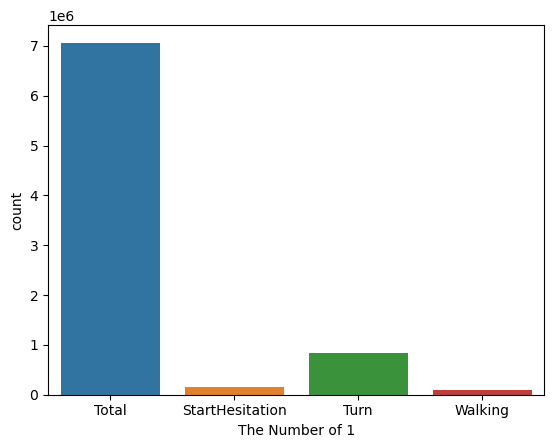

In [20]:
# Show the numbers by graph.
data = pd.DataFrame(
    np.concatenate([
        ['Total'] * len(tdcsfog),
        ['StartHesitation'] * int(np.ceil(len(tdcsfog) / 2 * tdcsfog['StartHesitation'].mean())),
        ['Turn'] * int(np.ceil(len(tdcsfog) / 2 * tdcsfog['Turn'].mean())),
        ['Walking'] * int(np.ceil(len(tdcsfog) / 2 * tdcsfog['Walking'].mean()))
    ]),
    columns = ["The Number of 1"]
)

sns.countplot(x = 'The Number of 1', data = data)

**Most of the target variables are 0.**

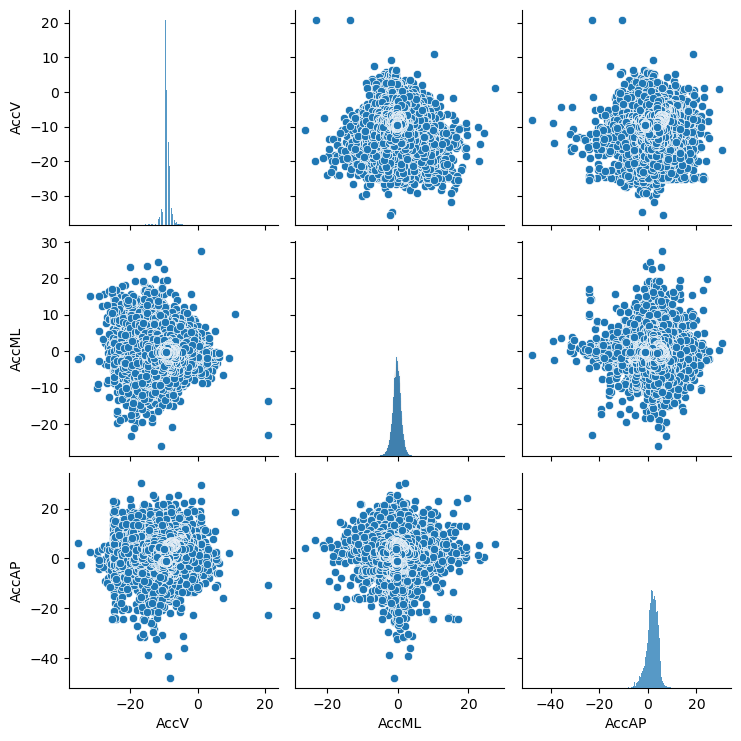

In [21]:
# Visualize "AccV", "AccML", and "AccAP."
sns.pairplot(tdcsfog[['AccV', 'AccML', 'AccAP']])

# The Relationship between Time and the 3 Events

We should analyze **to what extent the "Time" is relevant to occurrence of "StartHesitation", "Turn", and "Walking," respectively**.  Thus, we make a figure to show the relationships between "Time" (x-axis) and "StartHesitation", "Turn", and "Walking" (y-axis).

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


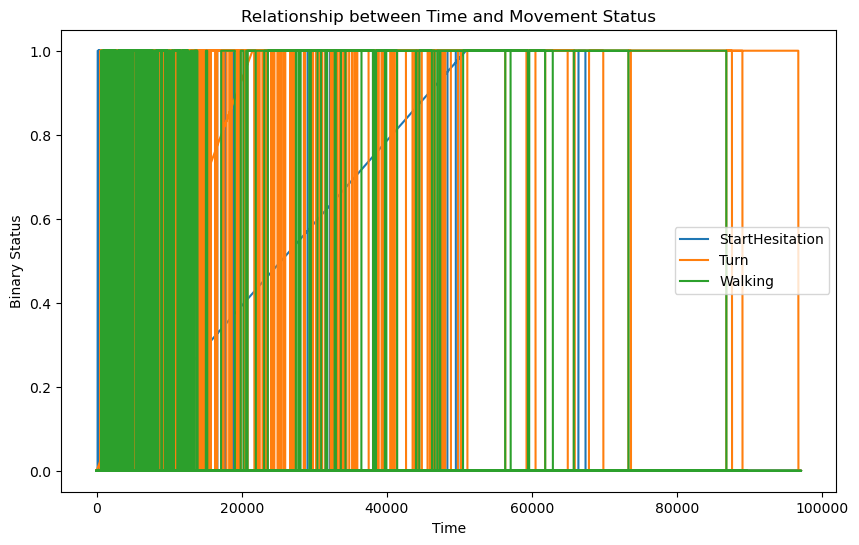

In [22]:
# Create a figure and axis object.
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the StartHesitation, Turn, and Walking columns against Time.
ax.plot(tdcsfog['Time'], tdcsfog['StartHesitation'], label = 'StartHesitation')
ax.plot(tdcsfog['Time'], tdcsfog['Turn'], label = 'Turn')
ax.plot(tdcsfog['Time'], tdcsfog['Walking'], label = 'Walking')

# Add axis labels and title.
ax.set_xlabel('Time')
ax.set_ylabel('Binary Status')
ax.set_title('Relationship between Time and Movement Status')

# Add a legend to the plot.
ax.legend()

# Show the plot.
plt.show()

Unfortunately, this figure above does not clearly show the relationships.

We create a line plot by **taking the means of the three values by time**. This code groups the tdcsfog dataframe by the "Time" column, takes the mean of the other columns for each group, and then resets the index to a sequential integer index. This code creates a figure with the mean values of "StartHesitation", "Turn", and "Walking" on the y-axis and "Time" on the x-axis. The rest of the code is the same as before.

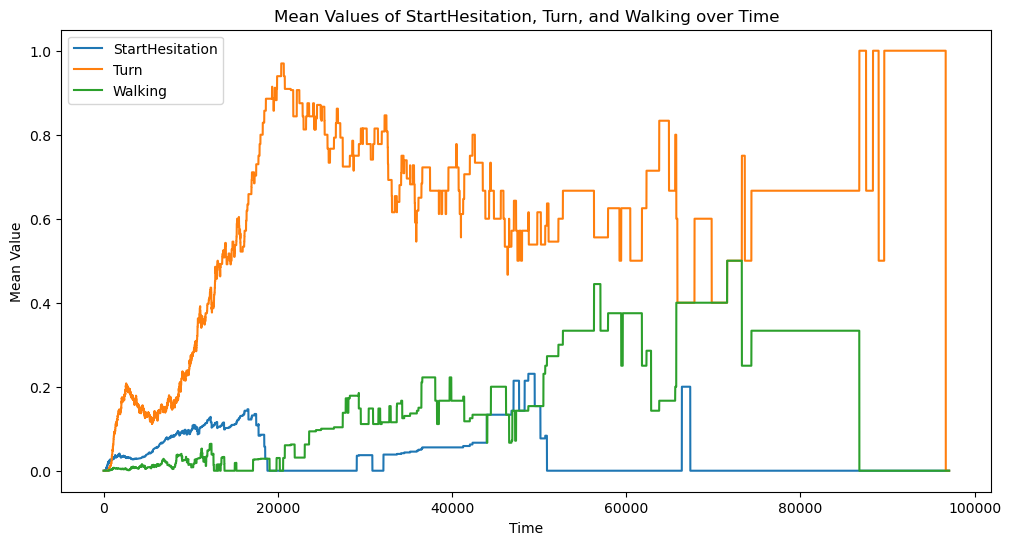

In [23]:
# Set the figure size.
plt.figure(figsize = (12,6))

# Calculates the mean values of all other columns for each unique value of Time.
# Reset the index of the resulting dataframe.
tdcsfog_means = tdcsfog.groupby('Time').mean().reset_index()

# Plot the mean StartHesitation values over time.
plt.plot(tdcsfog_means['Time'], tdcsfog_means['StartHesitation'], label = 'StartHesitation')

# Plot the mean Turn values over time.
plt.plot(tdcsfog_means['Time'], tdcsfog_means['Turn'], label = 'Turn')

# Plot the mean Walking values over time.
plt.plot(tdcsfog_means['Time'], tdcsfog_means['Walking'], label = 'Walking')

# Add a legend to the plot.
plt.legend()

# Set the x-label of the plot.
plt.xlabel('Time')

# Set the y-label of the plot.
plt.ylabel('Mean Value')

# Set the title of the plot.
plt.title('Mean Values of StartHesitation, Turn, and Walking over Time')

# Display the plot.
plt.show()

There may be some relationship between "Time" and the 3 Events. Particularly, **"StartHesitation" was more likely to occur at specific times**. **Positive correlation may exist between "Time" and "Walking."** However **the relationship is irregular**. It is not clear whether a prediction model had better include "Time" as an independent variable.

For the moment, we create **a model with "AccV", "AccML", and "AccAP," excluding "Time" to predict "StartHesitation", "Turn", and "Walking," respectively**.

## Take All the CSV Files in the Train defog Folder

In [24]:
# Set the directory path to the folder containing the CSV files.
defog_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog'

# Initialize an empty list to store the dataframes.
defog_list = []

# Loop through each file in the directory and read it into a dataframe.
for file_name in os.listdir(defog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_path, file_name)
        file = pd.read_csv(file_path)
        defog_list.append(file)

# Concatenate the dataframes vertically using pd.concat().
defog = pd.concat(defog_list, axis = 0)

# Show the concatenated dataframe.
defog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False
3,3,-0.998023,0.018378,0.068409,0,0,0,False,False
4,4,-0.998359,0.016726,0.066448,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
109120,109120,-0.939241,0.031564,-0.394737,0,0,0,False,False
109121,109121,-0.941096,0.031582,-0.392626,0,0,0,False,False
109122,109122,-0.940131,0.029092,-0.394385,0,0,0,False,False
109123,109123,-0.939872,0.028058,-0.398664,0,0,0,False,False


In [25]:
defog = reduce_memory_usage(defog)

Memory usage of dataframe is 851.34 MB
Memory usage became:  322.4778652191162  MB


**We are going to use valid data only.**

In [26]:
defog = defog[(defog['Task'] == 1) & (defog['Valid'] == 1)]

In [27]:
defog = defog.iloc[:, :7]

In [28]:
defog.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,4.111322e+06,4.111322e+06,4.111322e+06,4.111322e+06,4.111322e+06,4.111322e+06,4.111322e+06
mean,9.113573e+04,NaN,-0.000000e+00,NaN,2.140431e-05,1.007900e-01,1.715288e-02
std,7.020982e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.626430e-03,3.010504e-01,1.298409e-01
min,1.000000e+03,-6.023438e+00,-2.115234e+00,-5.117188e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.550000e+04,-9.848633e-01,-8.465576e-02,-3.640137e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.686400e+04,-9.389648e-01,0.000000e+00,-2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.294960e+05,-8.867188e-01,9.210205e-02,-1.135254e-01,0.000000e+00,0.000000e+00,0.000000e+00
max,4.143870e+05,4.457031e+00,4.523438e+00,4.386719e+00,1.000000e+00,1.000000e+00,1.000000e+00


**We merge tdcsfog and defog datasets into one merged dataset.**

In [29]:
# Concatenate the dataframes vertically using pd.concat().
merged = pd.concat([tdcsfog, defog], axis = 0)

# Show the concatenated dataframe.
merged

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.664062,0.042542,0.184692,0,0,0
1,1,-9.671875,0.049225,0.184692,0,0,0
2,2,-9.671875,0.033630,0.193848,0,0,0
3,3,-9.671875,0.035156,0.184326,0,0,0
4,4,-9.671875,0.043915,0.197754,0,0,0
...,...,...,...,...,...,...,...
108120,108120,-0.979004,0.043121,-0.392822,0,0,0
108121,108121,-0.949219,0.016144,-0.362549,0,0,0
108122,108122,-0.909668,-0.007553,-0.364502,0,0,0
108123,108123,-0.882324,-0.022476,-0.374023,0,0,0


## The previous version showed that the dataset only with tdcsfog lead to better prediction for 'Walking.'  Thus, we do not use the merged data for 'Walking' prediction.

# Create Dataset

First, we need to **split the data into input features (i.e., "AccV", "AccML", and "AccAP") and target variables (i.e., "StartHesitation", "Turn", and "Walking")**. We can do this using the .iloc method to select the appropriate columns.

In [30]:
X_merged = merged.iloc[:, 1:4]  # input features
X = tdcsfog.iloc[:, 1:4]  # input features
y1 = merged['StartHesitation']  # target variable for StartHesitation
y2 = merged['Turn']  # target variable for Turn
y3 = tdcsfog['Walking']  # target variable for Walking

Most of the target variables are 0. We had better **create each balanced dataset with the target variables of 0 and 1 equally**.

In [31]:
# Find the positions of y1 where it equals 0.
y1_zeros = np.where(y1 == 0)[0]
y1_ones = np.where(y1 == 1)[0]

# Choose the same number of samples with y1 == 1 as there are with y1 == 0.
num1_ones = (y1 == 1).sum()
np.random.seed(42)
y1_zeros = np.random.choice(np.where(y1 == 0)[0], size = num1_ones, replace = False)

# Combine the positions of y1 == 0 and y1 == 1.
y1_balanced_idxs = np.sort(np.concatenate([y1_zeros, y1_ones]))

# Use the balanced indices to get the corresponding rows of X and y1.
X1_balanced = X_merged.iloc[y1_balanced_idxs, :]
y1_balanced = y1.iloc[y1_balanced_idxs]

In [32]:
# Find the positions of y2 where it equals 0.
y2_zeros = np.where(y2 == 0)[0]
y2_ones = np.where(y2 == 1)[0]

# Choose the same number of samples with y2 == 1 as there are with y2 == 0.
num2_ones = (y2 == 1).sum()
np.random.seed(42)
y2_zeros = np.random.choice(np.where(y2 == 0)[0], size = num2_ones, replace = False)

# Combine the positions of y2 == 0 and y2 == 1.
y2_balanced_idxs = np.sort(np.concatenate([y2_zeros, y2_ones]))

# Use the balanced indices to get the corresponding rows of X and y1.
X2_balanced = X_merged.iloc[y2_balanced_idxs, :]
y2_balanced = y2.iloc[y2_balanced_idxs]

In [33]:
# Find the positions of y3 where it equals 0.
y3_zeros = np.where(y3 == 0)[0]
y3_ones = np.where(y3 == 1)[0]

# Choose the same number of samples with y3 == 1 as there are with y3 == 0.
num3_ones = (y3 == 1).sum()
np.random.seed(42)
y3_zeros = np.random.choice(np.where(y3 == 0)[0], size = num3_ones, replace = False)

# Combine the positions of y3 == 0 and y3 == 1.
y3_balanced_idxs = np.sort(np.concatenate([y3_zeros, y3_ones]))

# Use the balanced indices to get the corresponding rows of X and y3.
X3_balanced = X.iloc[y3_balanced_idxs, :]
y3_balanced = y3.iloc[y3_balanced_idxs]

Next, we can **split the data into training and testing sets using the train_test_split function from scikit-learn**.

In [34]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1_balanced, y1_balanced, test_size = 0.2, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_balanced, y2_balanced, test_size = 0.2, random_state = 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_balanced, y3_balanced, test_size = 0.2, random_state = 42)

# Create, Train, and Evaluate Model

Finally, we can **create and train three separate models**, one for each target variable, using a suitable algorithm, such as **logistic regression**.

\begin{equation*}
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^T\boldsymbol{\beta}}}
\end{equation*}

where: $P(y=1 \mid \mathbf{x})$ is the probability of the positive class given the input features $\mathbf{x}$,
       $\mathbf{x}^T$ is the transpose of the input feature vector,
       $\boldsymbol{\beta}$ is the parameter vector (coefficients),
       $e$ is the exponential function.

In [35]:
from sklearn.linear_model import LogisticRegression

# Create three separate logistic regression models.
model1 = LogisticRegression()
model2 = LogisticRegression()
model3 = LogisticRegression()

# Train the models on the training data.
model1.fit(X1_train, y1_train)
model2.fit(X2_train, y2_train)
model3.fit(X3_train, y3_train)

# Evaluate the models on the test data.
print('Accuracy for StartHesitation:', model1.score(X1_test, y1_test))
print('Accuracy for Turn:', model2.score(X2_test, y2_test))
print('Accuracy for Walking:', model3.score(X3_test, y3_test))

Accuracy for StartHesitation: 0.7558547625295198
Accuracy for Turn: 0.6409906063193851
Accuracy for Walking: 0.7036662817551963


**Based on the accuracy scores in the old version without making balanced data, the model performed well for StartHesitation and Walking, with accuracy scores of 0.956 and 0.970, respectively.** The model had a lower accuracy score of 0.758 for Turn classification.

**This time accuracy was lower, but actually, the performance level might be better.**

It's also important to consider other metrics like **precision, recall, and F1-score** to evaluate the model's performance in more detail.

\begin{equation*}
Accuracy: Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation*}

\begin{equation*}
Precision: Precision = \frac{TP}{TP + FP}
\end{equation*}

\begin{equation*}
Recall: Recall = \frac{TP}{TP + FN}
\end{equation*}

\begin{equation*}
F1-Score: F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{equation*}

where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

## To create a classification report and confusion matrix, we will need to use the predictions made by the models with the test data.

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the predictions for the three models on the test data.
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)
y3_pred = model3.predict(X3_test)

# Create a classification report for each model.
print('Classification Report for StartHesitation:')
print(classification_report(y1_test, y1_pred))

print('Classification Report for Turn:')
print(classification_report(y2_test, y2_pred))

print('Classification Report for Walking:')
print(classification_report(y3_test, y3_pred))

# Create a confusion matrix for each model.
print('Confusion Matrix for StartHesitation:')
print(confusion_matrix(y1_test, y1_pred))

print('Confusion Matrix for Turn:')
print(confusion_matrix(y2_test, y2_pred))

print('Confusion Matrix for Walking:')
print(confusion_matrix(y3_test, y3_pred))

Classification Report for StartHesitation:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74     60924
           1       0.73      0.82      0.77     61028

    accuracy                           0.76    121952
   macro avg       0.76      0.76      0.75    121952
weighted avg       0.76      0.76      0.75    121952

Classification Report for Turn:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65    419297
           1       0.65      0.62      0.63    417968

    accuracy                           0.64    837265
   macro avg       0.64      0.64      0.64    837265
weighted avg       0.64      0.64      0.64    837265

Classification Report for Walking:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     41326
           1       0.70      0.73      0.71     41810

    accuracy                           0.70     83136
   macro avg      

**Previously, tdcsfog and defog were not merged and tdcsfog was only used**, and **the models performed reasonably well**, with accuracies ranging from 0.60 to 0.71. The precision and recall scores are also **relatively balanced for each class**, indicating that **the models are not overly biased** towards predicting one class over the other.

**The results were much better than those of the old version without making balanced datasets!**

After **merging tdcsfog and defog**, the set of **classification reports and confusion matrices seem to be better**. The precision, recall and f1-scores are generally higher in the set of reports, while the accuracy is also higher for all three categories. Additionally, the confusion matrices in the merged set show **a better balance between true positives and true negatives**, which indicates that the model is performing better overall.

## Confusion Matrix for StartHesitation

Text(50.72222222222221, 0.5, 'Truth')

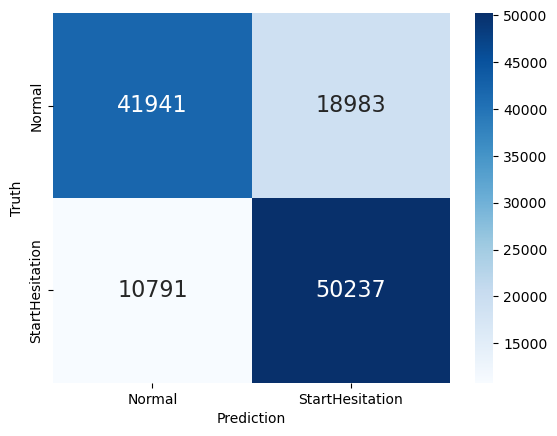

In [37]:
cm = confusion_matrix(y1_test, y1_pred)

# Define the class names.
class_names = ['Normal', 'StartHesitation']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

## Confusion Matrix for Turn

Text(50.722222222222214, 0.5, 'Truth')

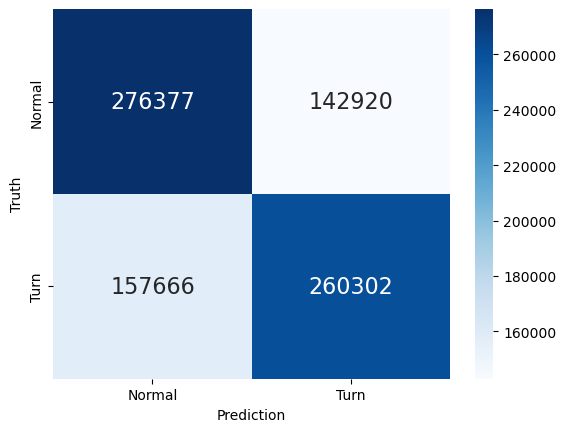

In [38]:
cm = confusion_matrix(y2_test, y2_pred)

# Define the class names.
class_names = ['Normal', 'Turn']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

## Confusion Matrix for Walking

Text(50.722222222222214, 0.5, 'Truth')

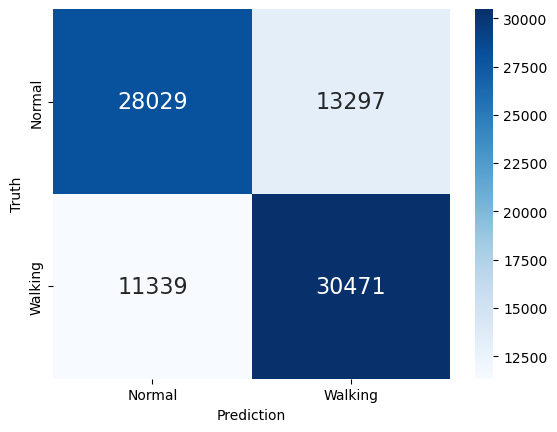

In [39]:
cm = confusion_matrix(y3_test, y3_pred)

# Define the class names.
class_names = ['Normal', 'Walking']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

# Create Test Dataset

In [40]:
# Set the directory path to the folder containing the CSV files.
tdcsfog_test_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog'

# Initialize an empty list to store the dataframes.
tdcsfog_test_list = []

# Loop through each file in the directory and read it into a dataframe.
for file_name in os.listdir(tdcsfog_test_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(tdcsfog_test_path, file_name)
        file = pd.read_csv(file_path)
        file['Id'] = file_name[:-4] + '_' + file['Time'].apply(str)
        tdcsfog_test_list.append(file)

# Concatenate the dataframes vertically using pd.concat().
tdcsfog_test = pd.concat(tdcsfog_test_list, axis = 0)

# Show the concatenated dataframe.
tdcsfog_test

,Time,AccV,AccML,AccAP,Id
0,0,-9.533939,0.566322,-1.413525,003f117e14_0
1,1,-9.536140,0.564137,-1.440621,003f117e14_1
2,2,-9.529345,0.561765,-1.429332,003f117e14_2
3,3,-9.531239,0.564227,-1.415490,003f117e14_3
4,4,-9.540825,0.561854,-1.429471,003f117e14_4
...,...,...,...,...,...
4677,4677,-9.351431,0.370047,-2.286318,003f117e14_4677
4678,4678,-9.341410,0.347721,-2.321991,003f117e14_4678
4679,4679,-9.350667,0.361341,-2.297158,003f117e14_4679
4680,4680,-9.343977,0.365726,-2.292650,003f117e14_4680


In [41]:
tdcsfog_test = reduce_memory_usage(tdcsfog_test)

Memory usage of dataframe is 0.18 MB
Memory usage became:  0.20650863647460938  MB


In [42]:
# Set the directory path to the folder containing the CSV files.
defog_test_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog'

# Initialize an empty list to store the dataframes.
defog_test_list = []

# Loop through each file in the directory and read it into a dataframe.
for file_name in os.listdir(defog_test_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_test_path, file_name)
        file = pd.read_csv(file_path)
        file['Id'] = file_name[:-4] + '_' + file['Time'].apply(str)
        defog_test_list.append(file)

# Concatenate the dataframes vertically using pd.concat().
defog_test = pd.concat(defog_test_list, axis = 0)

# Show the concatenated dataframe.
defog_test

,Time,AccV,AccML,AccAP,Id
0,0,-0.914652,-0.300851,0.298156,02ab235146_0
1,1,-0.914367,-0.301572,0.298325,02ab235146_1
2,2,-0.779540,-0.343197,0.275690,02ab235146_2
3,3,-0.993162,-0.270281,0.315775,02ab235146_3
4,4,-0.948767,-0.307849,0.297191,02ab235146_4
...,...,...,...,...,...
281683,281683,-0.899299,-0.232668,0.389147,02ab235146_281683
281684,281684,-0.901973,-0.233051,0.390114,02ab235146_281684
281685,281685,-0.901690,-0.231888,0.391896,02ab235146_281685
281686,281686,-0.899576,-0.232429,0.391106,02ab235146_281686


In [43]:
defog_test = reduce_memory_usage(defog_test)

Memory usage of dataframe is 10.75 MB
Memory usage became:  13.972709655761719  MB


In [44]:
test = pd.concat([tdcsfog_test, defog_test], axis = 0).reset_index(drop = True)
test

,Time,AccV,AccML,AccAP,Id
0,0,-9.531250,0.566406,-1.413086,003f117e14_0
1,1,-9.539062,0.563965,-1.440430,003f117e14_1
2,2,-9.531250,0.561523,-1.429688,003f117e14_2
3,3,-9.531250,0.564453,-1.415039,003f117e14_3
4,4,-9.539062,0.562012,-1.429688,003f117e14_4
...,...,...,...,...,...
286365,281683,-0.899414,-0.232666,0.389160,02ab235146_281683
286366,281684,-0.901855,-0.233032,0.390137,02ab235146_281684
286367,281685,-0.901855,-0.231934,0.391846,02ab235146_281685
286368,281686,-0.899414,-0.232422,0.391113,02ab235146_281686


# Inference

In [45]:
# Separate the dataset for the independent variables.
test_X = test.iloc[:, 1:4]

# Get the predictions for the three models on the test data.
pred_y1 = model1.predict(test_X)
pred_y2 = model2.predict(test_X)
pred_y3 = model3.predict(test_X)

test['StartHesitation'] = pred_y1 # target variable for StartHesitation
test['Turn'] = pred_y2 # target variable for Turn
test['Walking'] = pred_y3 # target variable for Walking

test

,Time,AccV,AccML,AccAP,Id,StartHesitation,Turn,Walking
0,0,-9.531250,0.566406,-1.413086,003f117e14_0,0,0,0
1,1,-9.539062,0.563965,-1.440430,003f117e14_1,0,0,0
2,2,-9.531250,0.561523,-1.429688,003f117e14_2,0,0,0
3,3,-9.531250,0.564453,-1.415039,003f117e14_3,0,0,0
4,4,-9.539062,0.562012,-1.429688,003f117e14_4,0,0,0
...,...,...,...,...,...,...,...,...
286365,281683,-0.899414,-0.232666,0.389160,02ab235146_281683,0,0,0
286366,281684,-0.901855,-0.233032,0.390137,02ab235146_281684,0,0,0
286367,281685,-0.901855,-0.231934,0.391846,02ab235146_281685,0,0,0
286368,281686,-0.899414,-0.232422,0.391113,02ab235146_281686,0,0,0


# Submission

In [46]:
submission = test.iloc[:, 4:].fillna(0.0)
submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
...,...,...,...,...
286365,02ab235146_281683,0,0,0
286366,02ab235146_281684,0,0,0
286367,02ab235146_281685,0,0,0
286368,02ab235146_281686,0,0,0


In [47]:
submission.to_csv("submission.csv", index = False)

# Save, Load, and Use Model

To save the trained Logistic Regression model, you can use the joblib library from the sklearn.externals module. This will save the model to a file in the current working directory. **To load the saved model later**, we can use the joblib.load() function.

In [48]:
import joblib

# Save the model to disk.
joblib.dump(model1, 'model1.joblib')
joblib.dump(model2, 'model2.joblib')
joblib.dump(model3, 'model3.joblib')

# Load the saved models from disk.
model1_loaded = joblib.load('model1.joblib')
model2_loaded = joblib.load('model2.joblib')
model3_loaded = joblib.load('model3.joblib')

# Use the loaded models to make predictions on test data.
y1_pred_loaded = model1_loaded.predict(test_X)
y2_pred_loaded = model2_loaded.predict(test_X)
y3_pred_loaded = model3_loaded.predict(test_X)

# Conclusion

It is possible that **more features or more advanced machine learning algorithms** could improve the accuracy of the models. Additionally, it may be useful to **investigate other factors** that contribute to the occurrence of freezing of gait events, such as cognitive or environmental factors.

I am a medical doctor working on **artificial intelligence (AI) for medicine**. At present AI is also widely used in the medical field. Particularly, AI performs in the healthcare sector following tasks: **image classification, object detection, semantic segmentation, GANs, text classification, etc**. **If you are interested in AI for medicine, please see my other notebooks.**